<a href="https://colab.research.google.com/github/YamanShqeirat/sahde-ml/blob/main/ShadeML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1: Environment Setup & Data Organization

### 0.1 Environment & Library versions (Colab)

In [28]:
# Colab environemnt set up
!pip -q install pandas pyarrow fastparquet geopandas shapely rasterio scikit-learn matplotlib seaborn

import os, sys, json, textwrap, zipfile, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import geopandas as gpd
import rasterio

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)

print("Python version:", sys.version)
print("Pandas:", pd.__version__)
print("Numpy:", np.__version__)
print("Scikit-learn:", sklearn.__version__)
print("GeoPandas:", gpd.__version__)
print("Rasterio:", rasterio.__version__)

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Pandas: 2.2.2
Numpy: 2.0.2
Scikit-learn: 1.6.1
GeoPandas: 1.1.1
Rasterio: 1.4.3


### 0.2 Mount Google Drive and set up project directories

In [34]:
from google.colab import drive
drive.mount('/content/drive')

PROJECT_ROOT = "/content/drive/MyDrive/CSE475 - Final Project"

RANDOM_STATE = 42

# Standard subfolders
RAW_DIR     = os.path.join(PROJECT_ROOT, "Datasets")        # raw uploads
INTERIM_DIR = os.path.join(PROJECT_ROOT, "interim")         # cleaned/intermediate
REPORTS_DIR = os.path.join(PROJECT_ROOT, "reports_figures") # charts/tables

for p in [INTERIM_DIR, REPORTS_DIR]:
    os.makedirs(p, exist_ok=True)

print("\nProject root:", PROJECT_ROOT)
print("\nRAW_DIR:", RAW_DIR)
print("\nINTERIM_DIR:", INTERIM_DIR)
print("\nREPORTS_DIR:", REPORTS_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Project root: /content/drive/MyDrive/CSE475 - Final Project

RAW_DIR: /content/drive/MyDrive/CSE475 - Final Project/Datasets

INTERIM_DIR: /content/drive/MyDrive/CSE475 - Final Project/interim

REPORTS_DIR: /content/drive/MyDrive/CSE475 - Final Project/reports_figures


### 1.1 Inspect available raw datasets

In [35]:
from pathlib import Path
from collections import Counter

def walk_dir(d, exts=None):
    d = Path(d)
    for p in sorted(d.rglob("*")):
        if p.is_file():
            if exts is None or p.suffix.lower() in exts:
                size_mb = p.stat().st_size / (1024*1024)
                print(f"{p.relative_to(d)}  [{size_mb:,.2f} MB]")

ext_counts = Counter([p.suffix.lower() for p in files if p.is_file()])


# When no files are found
files = list(Path(RAW_DIR).rglob("*"))

if not files:
    print("No files found in RAW_DIR!")

# When files are found
print(f"Found {len(files)} files total.")
print("\n== RAW ==")
walk_dir(RAW_DIR, exts={".csv", ".zip", ".tif", ".geojson", ".parquet", ".xlsx"})
print("\nFile type counts:", ext_counts)


Found 6 files total.

== RAW ==
647_IET_measurements_50e72be656c7407bd07e316061beeb1d.csv  [0.10 MB]
All_LC_Sensor_Climate.csv  [34.10 MB]
GlobalLandTemperaturesByCity.csv  [508.15 MB]
HLS.L30.T12SVB.2024209T175727.v2.0.Fmask.tif  [1.50 MB]
LULC_temp_prediction.csv  [83.00 MB]
Where_Will_Tree_Planting_Improve_Urban_Heat_Health%3F.csv  [113.03 MB]

File type counts: Counter({'.csv': 5, '.tif': 1})


### 1.2 Load & validate core datasets (Kaggle GLT, CAP LTER IET)

In [13]:
# Confirming data integrity of main CSV files
from pathlib import Path
import pandas as pd

# --- Kaggle: Global Land Temperatures by City ---
kaggle_path = Path(RAW_DIR) / "GlobalLandTemperaturesByCity.csv"
if not kaggle_path.exists():
    folder_alt = Path(RAW_DIR) / "GlobalLandTemperaturesByCity"
    candidates = list(folder_alt.rglob("*.csv")) if folder_alt.exists() else []
    if candidates:
        kaggle_path = candidates[0]

print(f" Kaggle dataset path: {kaggle_path}")
temps_city = pd.read_csv(kaggle_path)
print(f" Loaded Kaggle temperature data: {temps_city.shape[0]:,} rows × {temps_city.shape[1]} columns")
display(temps_city.head(3))

# --- CAP LTER: IET Measurements ---
iet_candidates = sorted(Path(RAW_DIR).rglob("*IET*measurements*.csv"))
assert len(iet_candidates) >= 1, " IET measurements CSV not found in RAW_DIR"
iet_path = iet_candidates[0]

print(f"\n CAP LTER dataset path: {iet_path}")
iet = pd.read_csv(iet_path)
print(f" Loaded CAP LTER IET data: {iet.shape[0]:,} rows × {iet.shape[1]} columns")
display(iet.head(3))


 Kaggle dataset path: /content/drive/MyDrive/CSE475 - Final Project/Datasets/GlobalLandTemperaturesByCity.csv
 Loaded Kaggle temperature data: 8,599,212 rows × 7 columns


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E



 CAP LTER dataset path: /content/drive/MyDrive/CSE475 - Final Project/Datasets/647_IET_measurements_50e72be656c7407bd07e316061beeb1d.csv
 Loaded CAP LTER IET data: 3,360 rows × 3 columns


,Subject ID,period,temperature
0,1A,"Sat, 8pm-12am",25.144467
1,1P,"Sat, 8pm-12am",26.779625
2,1E,"Sat, 8pm-12am",27.218750


In [36]:
print("\n=== Loading Additional Raw Datasets ===\n")

from pathlib import Path
import pandas as pd
import rasterio

# 1) All_LC_Sensor_Climate.csv
lc_climate_candidates = list(Path(RAW_DIR).rglob("All_LC_Sensor_Climate*.csv"))
if lc_climate_candidates:
    lc_climate_path = lc_climate_candidates[0]
    print(" LC Sensor Climate path:", lc_climate_path)
    lc_climate = pd.read_csv(lc_climate_path)
    print(f" Loaded LC climate data: {lc_climate.shape[0]:,} rows × {lc_climate.shape[1]} columns")
    display(lc_climate.head(3))
else:
    print(" LC Sensor Climate dataset not found.")

# 2) LULC_temp_prediction.csv
lulc_candidates = list(Path(RAW_DIR).rglob("LULC_temp_prediction*.csv"))
if lulc_candidates:
    lulc_path = lulc_candidates[0]
    print("\n LULC prediction path:", lulc_path)
    lulc = pd.read_csv(lulc_path)
    print(f" Loaded LULC prediction data: {lulc.shape[0]:,} rows × {lulc.shape[1]} columns")
    display(lulc.head(3))
else:
    print(" LULC prediction dataset not found.")

# 3) Tree-planting / Heat-Health dataset
tree_candidates = list(Path(RAW_DIR).rglob("Where_Will_Tree_Planting*"))
if tree_candidates:
    tree_path = tree_candidates[0]
    print("\n Tree planting path:", tree_path)
    tree_df = pd.read_csv(tree_path)
    print(f" Loaded tree planting dataset: {tree_df.shape[0]:,} rows × {tree_df.shape[1]} columns")
    display(tree_df.head(3))
else:
    print(" Tree planting dataset not found.")

# 4) HLS Fmask raster (cloud/shade mask)
hls_candidates = list(Path(RAW_DIR).rglob("*.tif"))
if hls_candidates:
    hls_path = hls_candidates[0]
    print("\n HLS TIF path:", hls_path)
    with rasterio.open(hls_path) as src:
        print(" Raster CRS:", src.crs)
        print(" Raster size:", src.width, "x", src.height)
        print(" Raster bands:", src.count)
else:
    print(" No .tif files found for HLS.")



=== Loading Additional Raw Datasets ===

 LC Sensor Climate path: /content/drive/MyDrive/CSE475 - Final Project/Datasets/All_LC_Sensor_Climate.csv
 Loaded LC climate data: 259,244 rows × 16 columns


,Date,Hour,ibuttonID,Lat,Lon,Impervious Surface,Turf/Grass,Tree Canopy,Buildings,Regional Air Temperature,Regional Relative Humidity,Regional Wind Speed,Mean Landsat Land Surface Temperature,Sensor Recorded Air Temperature,City,Diel
0,6/11/2018,13:00,M04,36.16523,-115.10812,0.259719,0.377171,0.328371,0.034739,36.666667,6.0,0.0,48.563597,38.0,Las Vegas,Daytime
1,6/11/2018,13:00,VH09,36.23288,-115.21085,0.000000,0.816529,0.183471,0.000000,36.666667,6.0,0.0,42.936060,36.5,Las Vegas,Daytime
2,6/11/2018,13:00,H03,36.13335,-115.30010,0.486352,0.031431,0.482217,0.000000,36.666667,6.0,0.0,46.000578,35.5,Las Vegas,Daytime



 LULC prediction path: /content/drive/MyDrive/CSE475 - Final Project/Datasets/LULC_temp_prediction.csv
 Loaded LULC prediction data: 693,932 rows × 14 columns


,City,Latitude,Longitude,Impervious,Grass,Tree,Building,LST,Tair_pred25_75,Tair_pred95,Tair_pred25_75_nt,Tair_pred95_nt,Tair_diff_day,Tair_diff_nt
0,Baltimore,39.372907,-76.532530,0.028056,0.203889,0.701389,0.066667,28.1021,27.721166,32.160609,22.371962,24.869003,4.439443,2.497041
1,Baltimore,39.372639,-76.552723,0.146389,0.393611,0.255556,0.204444,31.6356,28.450265,32.318988,21.889037,24.748836,3.868723,2.859799
2,Baltimore,39.372630,-76.553420,0.371389,0.223056,0.227778,0.177778,31.9305,29.631663,33.329234,22.348018,25.723821,3.697571,3.375803



 Tree planting path: /content/drive/MyDrive/CSE475 - Final Project/Datasets/Where_Will_Tree_Planting_Improve_Urban_Heat_Health%3F.csv
 Loaded tree planting dataset: 72,246 rows × 194 columns


,OBJECTID,GEOID,NAME,State,County,ALAND,AWATER,B01001_001E,B01001_calc_pctGE65E,B01001_calc_pctGE65E_BOX_COX,B03002_calc_pctNHWhiteE,PCT_Pop_Minority,B01001_003E,B01001_027E,Total_Young_People,PCT_Young_People,B17020_calc_pctPovE,B25002_calc_pctVacE,B15002_calc_pctLTHSE,B08201_calc_pctNoVehE,B08201_calc_pctNoVehE_BOX_COX,B28002_calc_pctNoIntE,B18101_calc_pctDE,PCT_HH_Lives_Alone,B16004_calc_pctGE18LEAE,B01001_calc_pctDependE,PCT_HU_Built_Prior_1970,B25002_001E,B25002_calc_pctTotalOwnE,B25002_calc_pctTotalRentE,Mean_Annual_Est_PM2_5_μg_m3,CASTHMA_CrudePrev,Area_SqKm,Pop_Density_PPL_SqKm,Pop_Density_PPL_SqKm_BOX_COX,High_Summer_Mean_LST_F,PCT_TreeCanopy,PCT_TreeCanopy_BOX_COX,PCT_LackingCanopy,PCT_ImperviousSurfaces,WF_HousingDensity_MEAN,WF_HousingDensity_MEAN_BOX_COX,WF_Exp_Type_MEAN,WF_RiskToHome_Mean,WF_RiskToHome_Mean_BOX_COX,WF_HazardPotential_Mean,WF_HazardPotential_Mean_BOX_COX,Cnt_Rd_Inter,Cnt_Rd_Inter_Per_Sqkm,Cnt_Rd_Inter_Per_Sqkm_BOX_COX,count_property,count_fs_risk_100_year00,count_fs_risk_100_year30,pct_fs_risk_100_year00,pct_fs_risk_100_year00_BOX_COX,pct_fs_risk_100_year30,pct_fs_risk_100_year30_BOX_COX,Pct_Tract_Blw_SL_2050,Avg_Vul_2050,MAX_CC,...,Home_Hardening_Index_Cnty_Pctl,Air_Filtration_Index,Air_Filtration_Index_Nat_Rank,Air_Filtration_Index_Nat_Pctl,Air_Filtration_Index_Nat_Quan,Air_Filtration_Index_St_Rank,Air_Filtration_Index_St_Pctl,Air_Filtration_Index_Cnty_Rank,Air_Filtration_Index_Cnty_Pctl,Improved_Egress_Index,Improved_Egress_Index_Nat_Rank,Improved_Egress_Index_Nat_Pctl,Improved_Egress_Index_Nat_Quan,Improved_Egress_Index_St_Rank,Improved_Egress_Index_St_Pctl,Improved_Egress_Index_Cnty_Rank,Improved_Egress_Index_Cnty_Pctl,In_Flood_Aware_Index,In_Flood_Aware_Index_Nat_Rank,In_Flood_Aware_Index_Nat_Pctl,In_Flood_Aware_Index_Nat_Quan,In_Flood_Aware_Index_St_Rank,In_Flood_Aware_Index_St_Pctl,In_Flood_Aware_Index_Cnty_Rank,In_Flood_Aware_Index_Cnty_Pctl,In_Flood_Egress_Index,In_Flood_Egress_Index_Nat_Rank,In_Flood_Egress_Index_Nat_Pctl,In_Flood_Egress_Index_Nat_Quan,In_Flood_Egress_Index_St_Rank,In_Flood_Egress_Index_St_Pctl,In_Flood_Egress_Index_Cnty_Rank,In_Flood_Egress_Index_Cnty_Pctl,Pres_Open_Space_Index,Pres_Open_Space_Index_Nat_Rank,Pres_Open_Space_Index_Nat_Pctl,Pres_Open_Space_Index_Nat_Quan,Pres_Open_Space_Index_St_Rank,Pres_Open_Space_Index_St_Pctl,Pres_Open_Space_Index_Cnty_Rank,Pres_Open_Space_Index_Cnty_Pctl,Reduce_Imp_Surf_Index,Reduce_Imp_Surf_Index_Nat_Rank,Reduce_Imp_Surf_Index_Nat_Pctl,Reduce_Imp_Surf_Index_Nat_Quan,Reduce_Imp_Surf_Index_St_Rank,Reduce_Imp_Surf_Index_St_Pctl,Reduce_Imp_Surf_Index_Cnty_Rank,Reduce_Imp_Surf_Index_Cnty_Pctl,Restore_Builtup_Index,Restore_Builtup_Index_Nat_Rank,Restore_Builtup_Index_Nat_Pctl,Restore_Builtup_Index_Nat_Quan,Restore_Builtup_Index_St_Rank,Restore_Builtup_Index_St_Pctl,Restore_Builtup_Index_Cnty_Rank,Restore_Builtup_Index_Cnty_Pctl,intervention_score,Shape__Area,Shape__Length
0,1,48007950100,Census Tract 9501,Texas,Aransas County,474836653,467090161,5333,39.2,10.998628,80.1,19.9,72,214,286,5.362835,13.0,48.8,10.9,1.9,0.701909,15.6,20.8,35.2,3.8,52.6,14.4,4713,41.5,9.7,7.142283,8.5,482.785150,11,2.959684,99.245789,9.034360,3.051622,90.965640,1.590426,8.028874,2.454300,0.807294,0.011670,-4.158151,58.122018,5.623419,74,0.153277,-1.633409,8213.0,5151.0,5491.0,62.7,7.973103,66.9,8.027431,12.673260,0.584817,0,...,80.0,1.878177,4624,6.399059,1,538,10.241767,2,40.0,4.355830,66493,92.036819,3,4708,89.624976,5,100.0,2.407481,33854,46.858606,2,2377,45.250333,1,20.0,4.797237,71827,99.420029,3,5235,99.657339,5,100.0,4.313009,69056,95.584470,3,5118,97.430040,5,100.0,2.574799,24000,33.218908,1,1650,31.410623,1,20.0,3.385515,55486,76.801163,3,4253,80.963259,5,100.0,6,6.235799e+08,872715.395042
1,2,48007950200,Census Tract 9502,Texas,Aransas County,2685464,17605331,1085,42.8,11.601322,84.3,15.7,33,33,66,6.082949,2.9,62.0,0.4,3.1,1.326916,10.2,12.8,41.6,0.5,53.1,14.5,1595,28.3,9.7,7.201200,7.3,2.790051,389,10.323019,94.477371,1.186391,0.175108,98.813609,51.15


 HLS TIF path: /content/drive/MyDrive/CSE475 - Final Project/Datasets/HLS.L30.T12SVB.2024209T175727.v2.0.Fmask.tif
 Raster CRS: EPSG:32612
 Raster size: 3660 x 3660
 Raster bands: 1


### 1.3 Inspect schema and normalize column names

In [37]:
# What columns do I have, and what do they look like?

# Are the column names consistent and easy to work with?

# Are dates properly formatted (as datetimes, not strings)?

def peek(df, name, n=3):
    print(f"\n=== {name} ===")
    print("Shape:", df.shape)
    display(df.sample(min(n, len(df))).head(n))
    print(df.dtypes.head(20))

peek(temps_city, "GlobalLandTemperaturesByCity")
peek(iet, "CAP-LTER IET measurements")

def clean_cols(df):
    return df.rename(columns={c: c.strip().lower().replace(" ", "_") for c in df.columns})

# ---- Standardize column names for all datasets (where available) ----

datasets = {
    "temps_city": temps_city,
    "iet": iet,
    "lc_climate": lc_climate if 'lc_climate' in globals() else None,
    "lulc": lulc if 'lulc' in globals() else None,
    "tree_df": tree_df if 'tree_df' in globals() else None
}

for name, df in datasets.items():
    if df is None:
        print(f"\n{name}: Not loaded, skipping.")
        continue
    print(f"\nCleaning column names for {name} ...")
    df = clean_cols(df)
    datasets[name] = df  # update reference

temps_city = datasets["temps_city"]
iet        = datasets["iet"]

if "lc_climate" in datasets: lc_climate = datasets["lc_climate"]
if "lulc" in datasets: lulc = datasets["lulc"]
if "tree_df" in datasets: tree_df = datasets["tree_df"]

possible_date_cols = ["dt", "date", "time", "timestamp", "day"]

for name, df in datasets.items():
    if df is None:
        continue
    print(f"\nParsing date columns in {name} ...")
    for col in df.columns:
        if any(key in col for key in possible_date_cols):
            try:
                df[col] = pd.to_datetime(df[col], errors="ignore")
            except:
                pass

print("\n=== Schema inspection for ALL datasets ===")
for name, df in datasets.items():
    if df is not None:
        peek(df, name)



=== GlobalLandTemperaturesByCity ===
Shape: (8599212, 7)


,dt,averagetemperature,averagetemperatureuncertainty,city,country,latitude,longitude
5592374,1881-06-01,12.532,2.221,Paarl,South Africa,-34.56,19.46
5426867,1902-12-01,24.432,2.428,Ogbomosho,Nigeria,8.84,4.05
6878451,1975-11-01,-1.609,0.435,Severodvinsk,Russia,65.09,40.21


dt                               datetime64[ns]
averagetemperature                      float64
averagetemperatureuncertainty           float64
city                                     object
country                                  object
latitude                                float64
longitude                               float64
dtype: object

=== CAP-LTER IET measurements ===
Shape: (3360, 3)


,subject_id,period,temperature
1590,5A,"Wed, 12am-4am",25.906250
3069,2L,"Sat, 4am-8am",23.958250
811,2P,"Mon, 12pm-4pm",29.041687


subject_id      object
period          object
temperature    float64
dtype: object

Cleaning column names for temps_city ...

Cleaning column names for iet ...

Cleaning column names for lc_climate ...

Cleaning column names for lulc ...

Cleaning column names for tree_df ...

Parsing date columns in temps_city ...

Parsing date columns in iet ...

Parsing date columns in lc_climate ...

Parsing date columns in lulc ...

Parsing date columns in tree_df ...

=== Schema inspection for ALL datasets ===

=== temps_city ===
Shape: (8599212, 7)


,dt,averagetemperature,averagetemperatureuncertainty,city,country,latitude,longitude
3611033,1876-03-01,-1.892,2.326,Kamyshin,Russia,50.63,44.37
6769084,1986-06-01,26.404,0.373,Sapele,Nigeria,5.63,6.46
1624141,1921-12-01,25.268,0.701,Ciampea,Indonesia,-7.23,106.22


dt                               datetime64[ns]
averagetemperature                      float64
averagetemperatureuncertainty           float64
city                                     object
country                                  object
latitude                                float64
longitude                               float64
dtype: object

=== iet ===
Shape: (3360, 3)


,subject_id,period,temperature
2198,3R,"Thu, 8am-12pm",31.854125
70,5A,"Sat, 8pm-12am",32.229125
213,4E,"Sun, 4am-8am",25.500000


subject_id      object
period          object
temperature    float64
dtype: object

=== lc_climate ===
Shape: (259244, 16)


,date,hour,ibuttonid,lat,lon,impervious_surface,turf/grass,tree_canopy,buildings,regional_air_temperature,regional_relative_humidity,regional_wind_speed,mean_landsat_land_surface_temperature,sensor_recorded_air_temperature,city,diel
251496,8/4/2018,1:00,L08_135,25.801028,-80.369345,0.898860,0.042735,0.058405,0.000000,27.222222,84.0,7.666667,41.727500,26.0,Miami,Nighttime
48705,19-09-02,13:00,H14_98,32.218710,-110.901550,0.285771,0.000000,0.301742,0.078141,36.666667,25.0,6.000000,48.455791,38.1,Tucson,Daytime
98854,8/8/2017,13:00,VH01,45.512420,-122.736780,0.288244,0.303116,0.261331,0.147309,28.703704,50.0,7.333333,34.191449,26.6,Portland,Daytime


date                                      object
hour                                      object
ibuttonid                                 object
lat                                      float64
lon                                      float64
impervious_surface                       float64
turf/grass                               float64
tree_canopy                              float64
buildings                                float64
regional_air_temperature                 float64
regional_relative_humidity               float64
regional_wind_speed                      float64
mean_landsat_land_surface_temperature    float64
sensor_recorded_air_temperature          float64
city                                      object
diel                                      object
dtype: object

=== lulc ===
Shape: (693932, 14)


,city,latitude,longitude,impervious,grass,tree,building,lst,tair_pred25_75,tair_pred95,tair_pred25_75_nt,tair_pred95_nt,tair_diff_day,tair_diff_nt
609316,Tucson,32.272243,-110.877329,0.003748,0.00885,0.273844,0.111724,47.9934,39.128599,43.424616,26.735987,30.846818,1970-01-01 00:00:00.000000004,4.110831
564859,Portland,45.472907,-122.537399,0.116667,0.00000,0.000000,0.051667,31.1782,26.263861,35.751511,17.096209,21.082160,1970-01-01 00:00:00.000000009,3.985951
585311,Portland,45.437155,-122.511609,0.417778,0.00000,0.000000,0.109722,37.7976,27.550609,36.565970,17.783256,21.635184,1970-01-01 00:00:00.000000009,3.851928


city                         object
latitude                    float64
longitude                   float64
impervious                  float64
grass                       float64
tree                        float64
building                    float64
lst                         float64
tair_pred25_75              float64
tair_pred95                 float64
tair_pred25_75_nt           float64
tair_pred95_nt              float64
tair_diff_day        datetime64[ns]
tair_diff_nt                float64
dtype: object

=== tree_df ===
Shape: (72246, 194)


,objectid,geoid,name,state,county,aland,awater,b01001_001e,b01001_calc_pctge65e,b01001_calc_pctge65e_box_cox,b03002_calc_pctnhwhitee,pct_pop_minority,b01001_003e,b01001_027e,total_young_people,pct_young_people,b17020_calc_pctpove,b25002_calc_pctvace,b15002_calc_pctlthse,b08201_calc_pctnovehe,b08201_calc_pctnovehe_box_cox,b28002_calc_pctnointe,b18101_calc_pctde,pct_hh_lives_alone,b16004_calc_pctge18leae,b01001_calc_pctdepende,pct_hu_built_prior_1970,b25002_001e,b25002_calc_pcttotalowne,b25002_calc_pcttotalrente,mean_annual_est_pm2_5_μg_m3,casthma_crudeprev,area_sqkm,pop_density_ppl_sqkm,pop_density_ppl_sqkm_box_cox,high_summer_mean_lst_f,pct_treecanopy,pct_treecanopy_box_cox,pct_lackingcanopy,pct_impervioussurfaces,wf_housingdensity_mean,wf_housingdensity_mean_box_cox,wf_exp_type_mean,wf_risktohome_mean,wf_risktohome_mean_box_cox,wf_hazardpotential_mean,wf_hazardpotential_mean_box_cox,cnt_rd_inter,cnt_rd_inter_per_sqkm,cnt_rd_inter_per_sqkm_box_cox,count_property,count_fs_risk_100_year00,count_fs_risk_100_year30,pct_fs_risk_100_year00,pct_fs_risk_100_year00_box_cox,pct_fs_risk_100_year30,pct_fs_risk_100_year30_box_cox,pct_tract_blw_sl_2050,avg_vul_2050,max_cc,...,home_hardening_index_cnty_pctl,air_filtration_index,air_filtration_index_nat_rank,air_filtration_index_nat_pctl,air_filtration_index_nat_quan,air_filtration_index_st_rank,air_filtration_index_st_pctl,air_filtration_index_cnty_rank,air_filtration_index_cnty_pctl,improved_egress_index,improved_egress_index_nat_rank,improved_egress_index_nat_pctl,improved_egress_index_nat_quan,improved_egress_index_st_rank,improved_egress_index_st_pctl,improved_egress_index_cnty_rank,improved_egress_index_cnty_pctl,in_flood_aware_index,in_flood_aware_index_nat_rank,in_flood_aware_index_nat_pctl,in_flood_aware_index_nat_quan,in_flood_aware_index_st_rank,in_flood_aware_index_st_pctl,in_flood_aware_index_cnty_rank,in_flood_aware_index_cnty_pctl,in_flood_egress_index,in_flood_egress_index_nat_rank,in_flood_egress_index_nat_pctl,in_flood_egress_index_nat_quan,in_flood_egress_index_st_rank,in_flood_egress_index_st_pctl,in_flood_egress_index_cnty_rank,in_flood_egress_index_cnty_pctl,pres_open_space_index,pres_open_space_index_nat_rank,pres_open_space_index_nat_pctl,pres_open_space_index_nat_quan,pres_open_space_index_st_rank,pres_open_space_index_st_pctl,pres_open_space_index_cnty_rank,pres_open_space_index_cnty_pctl,reduce_imp_surf_index,reduce_imp_surf_index_nat_rank,reduce_imp_surf_index_nat_pctl,reduce_imp_surf_index_nat_quan,reduce_imp_surf_index_st_rank,reduce_imp_surf_index_st_pctl,reduce_imp_surf_index_cnty_rank,reduce_imp_surf_index_cnty_pctl,restore_builtup_index,restore_builtup_index_nat_rank,restore_builtup_index_nat_pctl,restore_builtup_index_nat_quan,restore_builtup_index_st_rank,restore_builtup_index_st_pctl,restore_builtup_index_cnty_rank,restore_builtup_index_cnty_pctl,intervention_score,shape__area,shape__length
12079,12080,51710002600,Census Tract 26,Virginia,Norfolk city,848899,167670,4310,1.3,0.281054,34.8,65.2,25,47,72,1.670534,53.1,13.3,2.0,15.0,4.019193,5.9,3.7,34.6,3.2,4.7,39.3,1190,12.4,74.3,7.382446,12.2,0.874401,4929,19.062917,93.837898,2.922919,1.252696,97.077081,61.214433,1996.679051,14.394792,0.035955,0.000016,-9.310265,0.463992,-0.724701,20,22.872800,4.000879,815.0,289.0,472.0,35.5,6.241609,57.9,7.566900,2.404016,0.000000,0,...,3.750000,3.270292,45837,63.445221,2,1586,83.693931,58,72.500000,1.633828,8324,11.520520,1,56,2.955145,11,13.750000,3.495593,60890,84.281265,3,1744,92.031662,58,72.500000,2.676988,28575,39.551526,2,725,38.258575,47,58.750000,3.361551,45010,62.300505,2,1130,59.630607,58,72.500000,4.624980,70513,97.601218,3,1889,99.683377,79,98.750000,4.361492,70818,98.023393,3,1886,99.525066,77,96.250000,4,1.371895e+06,6786.488550
62741,62742,26163533700,Census Tract 5337,Michigan,Wayne County,836297,0,899,17.9,6.680289,1.3,98.7,33,8,41,4.560623,21.0,40.1,19.5,25.4,5.211500,51.1,20.0,43.3,2.7,32.6,94.2,710,26.2,33.7,9.777251,14.1,0.836298,1075,13.377407,98.47

objectid                          int64
geoid                             int64
name                             object
state                            object
county                           object
aland                             int64
awater                            int64
b01001_001e                       int64
b01001_calc_pctge65e            float64
b01001_calc_pctge65e_box_cox    float64
b03002_calc_pctnhwhitee         float64
pct_pop_minority                float64
b01001_003e                       int64
b01001_027e                       int64
total_young_people                int64
pct_young_people                float64
b17020_calc_pctpove             float64
b25002_calc_pctvace             float64
b15002_calc_pctlthse            float64
b08201_calc_pctnovehe           float64
dtype: object


# Section 2 – Data Loading & Cleaning

### 2.1 Clean CAP-LTER IET Dataset


In [39]:
# =============================================================
# 2.1 Clean CAP-LTER IET Dataset (period parsing + TOD bucketing)
# =============================================================

import re
import pandas as pd
import numpy as np

df = iet.copy()

# 1) Clean temperature column
df["temperature"] = pd.to_numeric(df["temperature"], errors="coerce")

# 2) Parse "Sat, 8pm-12am" style periods
day_map = {"Mon":0,"Tue":1,"Wed":2,"Thu":3,"Fri":4,"Sat":5,"Sun":6}

def to_24h(hh, ampm):
    hh = int(hh)
    if ampm.lower() == "am":
        return 0 if hh == 12 else hh
    return 12 if hh == 12 else hh + 12

def parse_period(s):
    m = re.match(r"\s*([A-Za-z]{3})\s*,\s*(\d{1,2})\s*([ap]m)\s*-\s*(\d{1,2})\s*([ap]m)\s*$",
                 str(s))
    if not m:
        return pd.Series([np.nan, np.nan, np.nan, np.nan],
                         index=["dow","start_hour","end_hour","duration_hr"])
    dow, h1, ampm1, h2, ampm2 = m.groups()
    s_h = to_24h(h1, ampm1)
    e_h = to_24h(h2, ampm2)
    duration = (e_h - s_h) % 24
    duration = 24 if duration == 0 else duration
    return pd.Series([day_map.get(dow, np.nan), s_h, e_h, duration],
                     index=["dow","start_hour","end_hour","duration_hr"])

parsed = df["period"].apply(parse_period)
df = pd.concat([df.drop(columns=["period"]), parsed], axis=1)

# 3) Time-of-day bucketing
def tod_bucket(h):
    if pd.isna(h): return np.nan
    h = int(h)
    if 5 <= h < 12:   return "morning"
    if 12 <= h < 17:  return "afternoon"
    if 17 <= h < 21:  return "evening"
    return "night"

df["tod"] = df["start_hour"].apply(tod_bucket)

# 4) Combine cleaned IET columns into iet_small
iet_small = pd.DataFrame()
required_cols = ["temperature", "dow", "start_hour", "duration_hr", "tod"]

for col in required_cols:
    if col in df.columns:
        iet_small[col] = df[col]
    else:
        print(f"Warning: missing column: {col}")

# Remove rows missing key fields
iet_small = iet_small.dropna(subset=["temperature", "dow", "start_hour", "tod"])

peek(iet_small, "IET cleaned subset")
print("IET shape:", iet_small.shape)



=== IET cleaned subset ===
Shape: (3219, 5)


,temperature,dow,start_hour,duration_hr,tod
2793,29.333437,4,12,4,afternoon
120,29.083375,6,0,4,night
1805,30.672625,2,12,4,afternoon


temperature    float64
dow              int64
start_hour       int64
duration_hr      int64
tod             object
dtype: object
IET shape: (3219, 5)


### 2.2 Clean Kaggle Arizona Temperature Data

In [40]:
# =============================================================
# 2.2 Clean Kaggle Phoenix Metro Temperature Dataset
# =============================================================

# --- Parse latitude/longitude strings ---
def parse_lat_lon(coord_str):
    if pd.isna(coord_str): return np.nan
    s = str(coord_str).strip()
    if s.endswith("N"): return float(s[:-1])
    if s.endswith("S"): return -float(s[:-1])
    if s.endswith("E"): return float(s[:-1])
    if s.endswith("W"): return -float(s[:-1])
    try:
        return float(s)
    except:
        return np.nan

temps_city["latitude"]  = temps_city["latitude"].apply(parse_lat_lon)
temps_city["longitude"] = temps_city["longitude"].apply(parse_lat_lon)

# --- Filter for Arizona cities ---
az_city_names = ["Phoenix", "Tempe", "Mesa", "Scottsdale", "Glendale"]
city_mask = temps_city["city"].isin(az_city_names)

latlon_mask = (
    (temps_city["country"] == "United States") &
    (temps_city["latitude"].between(31, 37)) &
    (temps_city["longitude"].between(-115, -109))
)

temps_az = temps_city[city_mask & latlon_mask].copy()

# Rename coordinate columns
temps_az = temps_az.rename(columns={"latitude":"lat", "longitude":"lon"})

# Rename temperature column if needed
if "averagetemperature" in temps_az.columns:
    temps_az = temps_az.rename(columns={"averagetemperature": "avg_temp_c"})

# Keep relevant columns
keep_cols = ["dt", "city", "country", "lat", "lon", "avg_temp_c"]
keep_cols = [c for c in keep_cols if c in temps_az.columns]
temps_az = temps_az[keep_cols].dropna(subset=["avg_temp_c", "lat", "lon"])

peek(temps_az, "Kaggle AZ cleaned subset")
print("Kaggle AZ shape:", temps_az.shape)



=== Kaggle AZ cleaned subset ===
Shape: (10695, 6)


,dt,city,country,lat,lon,avg_temp_c
7532062,1835-04-01,Tempe,United States,32.95,-112.02,18.443
7532660,1885-02-01,Tempe,United States,32.95,-112.02,12.814
6829365,1949-04-01,Scottsdale,United States,32.95,-112.02,20.716


dt            datetime64[ns]
city                  object
country               object
lat                  float64
lon                  float64
avg_temp_c           float64
dtype: object
Kaggle AZ shape: (10695, 6)


### 2.3 Clean LC Sensor Climate Dataset

In [41]:
# =============================================================
# 2.3 Clean Land-Cover Sensor Climate Dataset (All_LC_Sensor_Climate)
# =============================================================

if "lc_climate" not in globals() or lc_climate is None:
    print("lc_climate not loaded, skipping Section 2.3.")
else:
    print("Raw LC climate shape:", lc_climate.shape)
    peek(lc_climate, "LC climate (raw)")

    # Ensure columns are standardized
    lc_climate = clean_cols(lc_climate)

    # 1) Try to parse any obvious date/time column
    lc_date_candidates = [c for c in lc_climate.columns if any(x in c for x in ["date", "time", "timestamp", "datetime"])]
    for c in lc_date_candidates:
        try:
            lc_climate[c] = pd.to_datetime(lc_climate[c], errors="coerce")
            print(f"Parsed datetime column in lc_climate: {c}")
        except Exception as e:
            print(f"Could not parse datetime column {c}: {e}")

    # 2) Convert likely numeric climate variables
    numeric_like = [c for c in lc_climate.columns if any(x in c for x in ["temp", "tair", "rh", "humidity", "ws", "wind", "pressure"])]
    for c in numeric_like:
        lc_climate[c] = pd.to_numeric(lc_climate[c], errors="coerce")

    # 3) Drop rows with no climate values at all
    if numeric_like:
        lc_climate_clean = lc_climate.dropna(subset=numeric_like, how="all").copy()
    else:
        lc_climate_clean = lc_climate.copy()

    # 4) Optional: rename lat/lon
    rename_geo = {}
    if "latitude" in lc_climate_clean.columns and "lat" not in lc_climate_clean.columns:
        rename_geo["latitude"] = "lat"
    if "longitude" in lc_climate_clean.columns and "lon" not in lc_climate_clean.columns:
        rename_geo["longitude"] = "lon"
    if rename_geo:
        lc_climate_clean = lc_climate_clean.rename(columns=rename_geo)

    peek(lc_climate_clean, "LC climate (clean)")
    print("LC climate (clean) shape:", lc_climate_clean.shape)


Raw LC climate shape: (259244, 16)

=== LC climate (raw) ===
Shape: (259244, 16)


,date,hour,ibuttonid,lat,lon,impervious_surface,turf/grass,tree_canopy,buildings,regional_air_temperature,regional_relative_humidity,regional_wind_speed,mean_landsat_land_surface_temperature,sensor_recorded_air_temperature,city,diel
141844,2018-08-04,1:00,VH06,36.122680,-115.277090,0.000000,0.827243,0.172757,0.000000,34.444444,26.000000,6.000000,40.577668,29.1,Las Vegas,Nighttime
93345,2017-08-11,15:00,VL11,45.554989,-122.536711,0.894122,0.059136,0.046742,0.000000,28.518519,46.333333,7.666667,46.049284,29.8,Portland,Daytime
120886,NaT,13:00,M03_156,25.767606,-80.285902,0.462411,0.123404,0.207092,0.197163,32.592593,58.000000,9.333333,39.165000,34.0,Miami,Daytime


date                                     datetime64[ns]
hour                                             object
ibuttonid                                        object
lat                                             float64
lon                                             float64
impervious_surface                              float64
turf/grass                                      float64
tree_canopy                                     float64
buildings                                       float64
regional_air_temperature                        float64
regional_relative_humidity                      float64
regional_wind_speed                             float64
mean_landsat_land_surface_temperature           float64
sensor_recorded_air_temperature                 float64
city                                             object
diel                                             object
dtype: object
Parsed datetime column in lc_climate: date

=== LC climate (clean) ===
Shape: (259244, 16)

,date,hour,ibuttonid,lat,lon,impervious_surface,turf/grass,tree_canopy,buildings,regional_air_temperature,regional_relative_humidity,regional_wind_speed,mean_landsat_land_surface_temperature,sensor_recorded_air_temperature,city,diel
113899,NaT,13:00,VH11,39.364070,-76.617686,0.349449,0.184501,0.409527,0.056523,30.000000,46.0,9.000000,32.995509,30.2,Baltimore,Daytime
212669,2017-07-11,3:00,L14,45.507905,-122.581263,0.360482,0.203258,0.316926,0.119334,12.777778,75.0,4.666667,42.809945,12.6,Portland,Nighttime
90166,2017-07-03,14:00,VH14,45.466357,-122.675593,0.000000,0.000000,1.000000,0.000000,23.148148,42.0,7.000000,28.875650,20.6,Portland,Daytime


date                                     datetime64[ns]
hour                                             object
ibuttonid                                        object
lat                                             float64
lon                                             float64
impervious_surface                              float64
turf/grass                                      float64
tree_canopy                                     float64
buildings                                       float64
regional_air_temperature                        float64
regional_relative_humidity                      float64
regional_wind_speed                             float64
mean_landsat_land_surface_temperature           float64
sensor_recorded_air_temperature                 float64
city                                             object
diel                                             object
dtype: object
LC climate (clean) shape: (259244, 16)


### 2.4 Clean LULC Temprature Prediction Dataset

In [42]:
# =============================================================
# 2.4 Clean LULC Temperature Prediction Dataset (LULC_temp_prediction)
# =============================================================

if "lulc" not in globals() or lulc is None:
    print("lulc not loaded, skipping Section 2.4.")
else:
    print("Raw LULC shape:", lulc.shape)
    peek(lulc, "LULC (raw)")

    # Ensure standardized column names
    lulc = clean_cols(lulc)

    # 1) Parse any datetime columns
    lulc_date_candidates = [c for c in lulc.columns if any(x in c for x in ["date", "time", "timestamp", "datetime"])]
    for c in lulc_date_candidates:
        try:
            lulc[c] = pd.to_datetime(lulc[c], errors="coerce")
            print(f"Parsed datetime column in lulc: {c}")
        except Exception as e:
            print(f"Could not parse datetime column {c}: {e}")

    # 2) Normalize coordinate columns if present
    rename_geo = {}
    if "latitude" in lulc.columns and "lat" not in lulc.columns:
        rename_geo["latitude"] = "lat"
    if "longitude" in lulc.columns and "lon" not in lulc.columns:
        rename_geo["longitude"] = "lon"
    if rename_geo:
        lulc = lulc.rename(columns=rename_geo)

    # 3) Convert likely temperature / prediction columns to numeric
    lulc_temp_candidates = [c for c in lulc.columns if any(x in c for x in ["temp", "temperature", "pred", "prediction"])]
    for c in lulc_temp_candidates:
        lulc[c] = pd.to_numeric(lulc[c], errors="coerce")

    # 4) Drop rows missing all target-like columns, if any
    if lulc_temp_candidates:
        lulc_clean = lulc.dropna(subset=lulc_temp_candidates, how="all").copy()
    else:
        lulc_clean = lulc.copy()

    peek(lulc_clean, "LULC (clean)")
    print("LULC (clean) shape:", lulc_clean.shape)


Raw LULC shape: (693932, 14)

=== LULC (raw) ===
Shape: (693932, 14)


,city,latitude,longitude,impervious,grass,tree,building,lst,tair_pred25_75,tair_pred95,tair_pred25_75_nt,tair_pred95_nt,tair_diff_day,tair_diff_nt
602447,Tucson,32.283124,-110.967795,0.407611,0.000000,0.173758,0.355678,47.7298,39.404172,43.084736,27.183998,30.757371,1970-01-01 00:00:00.000000003,3.573373
237766,Las Vegas,36.115066,-115.253612,0.523997,0.000000,0.257725,0.218277,48.2094,41.440956,44.731441,29.670291,33.275896,1970-01-01 00:00:00.000000003,3.605605
246349,Las Vegas,36.103931,-115.125225,0.436538,0.015385,0.319872,0.228205,49.3877,40.244793,43.814673,28.765007,32.175811,1970-01-01 00:00:00.000000003,3.410804


city                         object
latitude                    float64
longitude                   float64
impervious                  float64
grass                       float64
tree                        float64
building                    float64
lst                         float64
tair_pred25_75              float64
tair_pred95                 float64
tair_pred25_75_nt           float64
tair_pred95_nt              float64
tair_diff_day        datetime64[ns]
tair_diff_nt                float64
dtype: object

=== LULC (clean) ===
Shape: (693932, 14)


,city,lat,lon,impervious,grass,tree,building,lst,tair_pred25_75,tair_pred95,tair_pred25_75_nt,tair_pred95_nt,tair_diff_day,tair_diff_nt
174558,Las Vegas,36.195839,-115.342571,0.767500,0.000000,0.000000,0.000000,46.454600,40.809880,45.069502,29.119265,33.249518,1970-01-01 00:00:00.000000004,4.130253
647131,Tucson,32.211037,-110.841121,0.438880,0.000000,0.079446,0.177947,46.765000,39.857717,43.851920,26.882133,31.129769,1970-01-01 00:00:00.000000003,4.247636
46350,Denver,39.797806,-104.902699,0.103889,0.021111,0.069167,0.000000,32.158838,30.398035,35.968583,17.534260,23.445692,1970-01-01 00:00:00.000000005,5.911432


city                         object
lat                         float64
lon                         float64
impervious                  float64
grass                       float64
tree                        float64
building                    float64
lst                         float64
tair_pred25_75              float64
tair_pred95                 float64
tair_pred25_75_nt           float64
tair_pred95_nt              float64
tair_diff_day        datetime64[ns]
tair_diff_nt                float64
dtype: object
LULC (clean) shape: (693932, 14)


### 2.5 Clean Tree-Planting / Urban Heat-Health Dataset

In [43]:
# =============================================================
# 2.5 Clean Tree-Planting / Urban Heat-Health Dataset
# =============================================================

if "tree_df" not in globals() or tree_df is None:
    print("tree_df not loaded, skipping Section 2.5.")
else:
    print("Raw tree-planting dataset shape:", tree_df.shape)
    peek(tree_df, "Tree planting / Heat-Health (raw)")

    # Ensure standardized column names
    tree_df = clean_cols(tree_df)

    # 1) Parse any date-like columns
    tree_date_candidates = [c for c in tree_df.columns if any(x in c for x in ["date", "time", "timestamp", "year"])]
    for c in tree_date_candidates:
        try:
            tree_df[c] = pd.to_datetime(tree_df[c], errors="coerce")
            print(f"Parsed datetime column in tree_df: {c}")
        except Exception as e:
            print(f"Could not parse datetime column {c}: {e}")

    # 2) Normalize coordinates if present
    rename_geo = {}
    if "latitude" in tree_df.columns and "lat" not in tree_df.columns:
        rename_geo["latitude"] = "lat"
    if "longitude" in tree_df.columns and "lon" not in tree_df.columns:
        rename_geo["longitude"] = "lon"
    if rename_geo:
        tree_df = tree_df.rename(columns=rename_geo)

    # 3) Convert obvious numeric indicators to numeric
    numeric_like = [c for c in tree_df.columns if any(x in c for x in [
        "temp", "temperature", "heat", "index", "score", "vulnerability", "exposure"
    ])]
    for c in numeric_like:
        tree_df[c] = pd.to_numeric(tree_df[c], errors="coerce")

    # 4) Drop rows missing all numeric metrics (if any were found)
    if numeric_like:
        tree_df_clean = tree_df.dropna(subset=numeric_like, how="all").copy()
    else:
        tree_df_clean = tree_df.copy()

    peek(tree_df_clean, "Tree planting / Heat-Health (clean)")
    print("Tree dataset (clean) shape:", tree_df_clean.shape)


Raw tree-planting dataset shape: (72246, 194)

=== Tree planting / Heat-Health (raw) ===
Shape: (72246, 194)


,objectid,geoid,name,state,county,aland,awater,b01001_001e,b01001_calc_pctge65e,b01001_calc_pctge65e_box_cox,b03002_calc_pctnhwhitee,pct_pop_minority,b01001_003e,b01001_027e,total_young_people,pct_young_people,b17020_calc_pctpove,b25002_calc_pctvace,b15002_calc_pctlthse,b08201_calc_pctnovehe,b08201_calc_pctnovehe_box_cox,b28002_calc_pctnointe,b18101_calc_pctde,pct_hh_lives_alone,b16004_calc_pctge18leae,b01001_calc_pctdepende,pct_hu_built_prior_1970,b25002_001e,b25002_calc_pcttotalowne,b25002_calc_pcttotalrente,mean_annual_est_pm2_5_μg_m3,casthma_crudeprev,area_sqkm,pop_density_ppl_sqkm,pop_density_ppl_sqkm_box_cox,high_summer_mean_lst_f,pct_treecanopy,pct_treecanopy_box_cox,pct_lackingcanopy,pct_impervioussurfaces,wf_housingdensity_mean,wf_housingdensity_mean_box_cox,wf_exp_type_mean,wf_risktohome_mean,wf_risktohome_mean_box_cox,wf_hazardpotential_mean,wf_hazardpotential_mean_box_cox,cnt_rd_inter,cnt_rd_inter_per_sqkm,cnt_rd_inter_per_sqkm_box_cox,count_property,count_fs_risk_100_year00,count_fs_risk_100_year30,pct_fs_risk_100_year00,pct_fs_risk_100_year00_box_cox,pct_fs_risk_100_year30,pct_fs_risk_100_year30_box_cox,pct_tract_blw_sl_2050,avg_vul_2050,max_cc,...,home_hardening_index_cnty_pctl,air_filtration_index,air_filtration_index_nat_rank,air_filtration_index_nat_pctl,air_filtration_index_nat_quan,air_filtration_index_st_rank,air_filtration_index_st_pctl,air_filtration_index_cnty_rank,air_filtration_index_cnty_pctl,improved_egress_index,improved_egress_index_nat_rank,improved_egress_index_nat_pctl,improved_egress_index_nat_quan,improved_egress_index_st_rank,improved_egress_index_st_pctl,improved_egress_index_cnty_rank,improved_egress_index_cnty_pctl,in_flood_aware_index,in_flood_aware_index_nat_rank,in_flood_aware_index_nat_pctl,in_flood_aware_index_nat_quan,in_flood_aware_index_st_rank,in_flood_aware_index_st_pctl,in_flood_aware_index_cnty_rank,in_flood_aware_index_cnty_pctl,in_flood_egress_index,in_flood_egress_index_nat_rank,in_flood_egress_index_nat_pctl,in_flood_egress_index_nat_quan,in_flood_egress_index_st_rank,in_flood_egress_index_st_pctl,in_flood_egress_index_cnty_rank,in_flood_egress_index_cnty_pctl,pres_open_space_index,pres_open_space_index_nat_rank,pres_open_space_index_nat_pctl,pres_open_space_index_nat_quan,pres_open_space_index_st_rank,pres_open_space_index_st_pctl,pres_open_space_index_cnty_rank,pres_open_space_index_cnty_pctl,reduce_imp_surf_index,reduce_imp_surf_index_nat_rank,reduce_imp_surf_index_nat_pctl,reduce_imp_surf_index_nat_quan,reduce_imp_surf_index_st_rank,reduce_imp_surf_index_st_pctl,reduce_imp_surf_index_cnty_rank,reduce_imp_surf_index_cnty_pctl,restore_builtup_index,restore_builtup_index_nat_rank,restore_builtup_index_nat_pctl,restore_builtup_index_nat_quan,restore_builtup_index_st_rank,restore_builtup_index_st_pctl,restore_builtup_index_cnty_rank,restore_builtup_index_cnty_pctl,intervention_score,shape__area,shape__length
23270,23271,48029162001,Census Tract 1620.01,Texas,Bexar County,46389995,503742,2122,12.1,5.098024,16.3,83.7,121,88,209,9.849199,14.3,11.6,31.5,3.2,1.370426,26.0,14.2,20.7,11.7,41.2,26.2,595,63.4,25.0,7.909431,8.6,46.893739,45,5.351120,111.877365,7.552241,2.726345,92.447759,2.449359,19.587717,3.769851,0.872064,0.014669,-3.958147,91.617535,6.498044,48,1.023591,0.023359,1017.0,225.0,227.0,22.1,5.000842,22.3,4.952452,NaN,0.572707,2,...,95.355191,2.294728,12707,17.587376,1,1892,36.017514,184,50.273224,4.130931,61868,85.634992,3,4353,82.866933,356,97.267760,3.461566,60186,83.306803,3,4325,82.333904,238,65.027322,4.341689,65529,90.702471,3,4928,93.813059,364,99.453552,4.299064,68891,95.356080,3,5111,97.296783,365,99.726776,2.647432,26296,36.396982,2,1773,33.752142,30,8.196721,3.709511,64246,88.926569,3,4805,91.471540,305,83.333333,3,6.184545e+07,43294.997970
48472,48473,18055954800,Census Tract 9548,Indiana,Greene County,214155232,2031982,3602,21.3,7.492834,98.5,1.5,141,73,214,5.941144,12.7,15.2,11.8,3.6,1.535194,22.8,24.0,29.4,1.1,45.1,49.4,1750,70.6,14.2,8.024282,10.1,214.7

objectid                          int64
geoid                             int64
name                             object
state                            object
county                           object
aland                             int64
awater                            int64
b01001_001e                       int64
b01001_calc_pctge65e            float64
b01001_calc_pctge65e_box_cox    float64
b03002_calc_pctnhwhitee         float64
pct_pop_minority                float64
b01001_003e                       int64
b01001_027e                       int64
total_young_people                int64
pct_young_people                float64
b17020_calc_pctpove             float64
b25002_calc_pctvace             float64
b15002_calc_pctlthse            float64
b08201_calc_pctnovehe           float64
dtype: object
Parsed datetime column in tree_df: count_fs_risk_100_year00
Parsed datetime column in tree_df: count_fs_risk_100_year30
Parsed datetime column in tree_df: pct_fs_risk_100_year00
Parsed d

,objectid,geoid,name,state,county,aland,awater,b01001_001e,b01001_calc_pctge65e,b01001_calc_pctge65e_box_cox,b03002_calc_pctnhwhitee,pct_pop_minority,b01001_003e,b01001_027e,total_young_people,pct_young_people,b17020_calc_pctpove,b25002_calc_pctvace,b15002_calc_pctlthse,b08201_calc_pctnovehe,b08201_calc_pctnovehe_box_cox,b28002_calc_pctnointe,b18101_calc_pctde,pct_hh_lives_alone,b16004_calc_pctge18leae,b01001_calc_pctdepende,pct_hu_built_prior_1970,b25002_001e,b25002_calc_pcttotalowne,b25002_calc_pcttotalrente,mean_annual_est_pm2_5_μg_m3,casthma_crudeprev,area_sqkm,pop_density_ppl_sqkm,pop_density_ppl_sqkm_box_cox,high_summer_mean_lst_f,pct_treecanopy,pct_treecanopy_box_cox,pct_lackingcanopy,pct_impervioussurfaces,wf_housingdensity_mean,wf_housingdensity_mean_box_cox,wf_exp_type_mean,wf_risktohome_mean,wf_risktohome_mean_box_cox,wf_hazardpotential_mean,wf_hazardpotential_mean_box_cox,cnt_rd_inter,cnt_rd_inter_per_sqkm,cnt_rd_inter_per_sqkm_box_cox,count_property,count_fs_risk_100_year00,count_fs_risk_100_year30,pct_fs_risk_100_year00,pct_fs_risk_100_year00_box_cox,pct_fs_risk_100_year30,pct_fs_risk_100_year30_box_cox,pct_tract_blw_sl_2050,avg_vul_2050,max_cc,...,home_hardening_index_cnty_pctl,air_filtration_index,air_filtration_index_nat_rank,air_filtration_index_nat_pctl,air_filtration_index_nat_quan,air_filtration_index_st_rank,air_filtration_index_st_pctl,air_filtration_index_cnty_rank,air_filtration_index_cnty_pctl,improved_egress_index,improved_egress_index_nat_rank,improved_egress_index_nat_pctl,improved_egress_index_nat_quan,improved_egress_index_st_rank,improved_egress_index_st_pctl,improved_egress_index_cnty_rank,improved_egress_index_cnty_pctl,in_flood_aware_index,in_flood_aware_index_nat_rank,in_flood_aware_index_nat_pctl,in_flood_aware_index_nat_quan,in_flood_aware_index_st_rank,in_flood_aware_index_st_pctl,in_flood_aware_index_cnty_rank,in_flood_aware_index_cnty_pctl,in_flood_egress_index,in_flood_egress_index_nat_rank,in_flood_egress_index_nat_pctl,in_flood_egress_index_nat_quan,in_flood_egress_index_st_rank,in_flood_egress_index_st_pctl,in_flood_egress_index_cnty_rank,in_flood_egress_index_cnty_pctl,pres_open_space_index,pres_open_space_index_nat_rank,pres_open_space_index_nat_pctl,pres_open_space_index_nat_quan,pres_open_space_index_st_rank,pres_open_space_index_st_pctl,pres_open_space_index_cnty_rank,pres_open_space_index_cnty_pctl,reduce_imp_surf_index,reduce_imp_surf_index_nat_rank,reduce_imp_surf_index_nat_pctl,reduce_imp_surf_index_nat_quan,reduce_imp_surf_index_st_rank,reduce_imp_surf_index_st_pctl,reduce_imp_surf_index_cnty_rank,reduce_imp_surf_index_cnty_pctl,restore_builtup_index,restore_builtup_index_nat_rank,restore_builtup_index_nat_pctl,restore_builtup_index_nat_quan,restore_builtup_index_st_rank,restore_builtup_index_st_pctl,restore_builtup_index_cnty_rank,restore_builtup_index_cnty_pctl,intervention_score,shape__area,shape__length
17712,17713,36081008600,Census Tract 86,New York,Queens County,332283,0,2846,10.4,4.567412,28.3,71.7,83,46,129,4.532677,11.2,6.7,16.1,16.4,4.209249,7.0,8.8,17.7,13.7,30.1,96.7,959,62.4,31.0,8.129236,8.5,0.332284,8565,21.517447,101.39320,0.464865,-0.688838,99.535135,88.338753,3481.000000,16.256155,0.000000,0.000000,-11.245139,0.000000,-5.766821,32,96.303120,6.575815,637.0,1970-01-01 00:00:00.000000003,1970-01-01 00:00:00.000000003,1970-01-01 00:00:00.000000000,1970-01-01 00:00:00.000000000,1970-01-01 00:00:00.000000000,1970-01-01 00:00:00.000000000,NaN,0.000000,0,...,57.335329,3.230436,44453,61.529518,2,2594,52.938776,429,64.221557,1.088238,2010,2.780815,1,1419,28.959184,358,53.592814,2.36584,32313,44.725587,2,1806,36.857143,137,20.508982,1.169687,1472,2.036127,1,1029,21.000000,236,35.329341,1.159940,1833,2.535816,1,859,17.530612,203,30.389222,3.690537,58627,81.148868,3,3404,69.469388,306,45.808383,2.362329,10743,14.868849,1,1491,30.428571,273,40.868263,1,5.741774e+05,3229.340064
23452,23453,48029191817,Census Tract 1918.17,Texas,Bexar County,12898324,1385,12785,13.3,5.4

objectid                          int64
geoid                             int64
name                             object
state                            object
county                           object
aland                             int64
awater                            int64
b01001_001e                       int64
b01001_calc_pctge65e            float64
b01001_calc_pctge65e_box_cox    float64
b03002_calc_pctnhwhitee         float64
pct_pop_minority                float64
b01001_003e                       int64
b01001_027e                       int64
total_young_people                int64
pct_young_people                float64
b17020_calc_pctpove             float64
b25002_calc_pctvace             float64
b15002_calc_pctlthse            float64
b08201_calc_pctnovehe           float64
dtype: object
Tree dataset (clean) shape: (72246, 194)


### 2.6 Inspect HLS Fmask Raster (Shade/Cloud Mask)

In [44]:
# =============================================================
# 2.6 Inspect HLS Fmask Raster (cloud/shadow mask)
# =============================================================

from pathlib import Path
import rasterio

hls_candidates = list(Path(RAW_DIR).rglob("HLS.L30*.tif"))
if not hls_candidates:
    hls_candidates = list(Path(RAW_DIR).rglob("*.tif"))

if not hls_candidates:
    print("No HLS .tif rasters found in RAW_DIR, skipping Section 2.6.")
else:
    hls_path = hls_candidates[0]
    print("HLS TIF path:", hls_path)

    with rasterio.open(hls_path) as src:
        hls_meta = src.meta.copy()
        print("Raster CRS:", src.crs)
        print("Raster size:", src.width, "x", src.height)
        print("Raster bands:", src.count)
        print("Transform:", src.transform)

        # Approx pixel size in map units (meters for UTM)
        px_width = src.transform[0]
        px_height = -src.transform[4]
        print("Pixel size:", px_width, "x", px_height)

    # keep hls_path and hls_meta for later spatial sampling


HLS TIF path: /content/drive/MyDrive/CSE475 - Final Project/Datasets/HLS.L30.T12SVB.2024209T175727.v2.0.Fmask.tif
Raster CRS: EPSG:32612
Raster size: 3660 x 3660
Raster bands: 1
Transform: | 30.00, 0.00, 399960.00|
| 0.00,-30.00, 3700020.00|
| 0.00, 0.00, 1.00|
Pixel size: 30.0 x 30.0


### 2.7 Dataset Summary

In [45]:
# =============================================================
# 2.7 Dataset Summary
# =============================================================

print("========== DATASET SUMMARY ==========\n")

def summarize_df(name, df, date_cols=None, lat_col=None, lon_col=None, temp_cols=None):
    print(f"--- {name} ---")
    print("Shape:", df.shape)

    # Date ranges
    if date_cols:
        for c in date_cols:
            if c in df.columns and pd.api.types.is_datetime64_any_dtype(df[c]):
                print(f"  {c}: {df[c].min()}  →  {df[c].max()}")

    # Lat/lon ranges
    if lat_col in df.columns:
        print(f"  {lat_col} range:", df[lat_col].min(), "→", df[lat_col].max())
    if lon_col in df.columns:
        print(f"  {lon_col} range:", df[lon_col].min(), "→", df[lon_col].max())

    # Temperature or numeric climate variable summary
    if temp_cols:
        for t in temp_cols:
            if t in df.columns:
                print(f"  {t} stats:")
                display(df[t].describe())

    print("\n")


# --- Kaggle AZ temperatures ---
if "temps_az" in globals():
    summarize_df(
        "Kaggle AZ Temperature Subset",
        temps_az,
        date_cols=["dt"],
        lat_col="lat",
        lon_col="lon",
        temp_cols=["avg_temp_c"]
    )

# --- IET microclimate dataset ---
if "iet_small" in globals():
    summarize_df(
        "IET Microclimate Measurements",
        iet_small,
        date_cols=["date"] if "date" in iet_small.columns else None,
        lat_col="lat" if "lat" in iet_small.columns else None,
        lon_col="lon" if "lon" in iet_small.columns else None,
        temp_cols=["temperature"]
    )

# --- LC Sensor Climate ---
if "lc_climate_clean" in globals():
    summarize_df(
        "LC Sensor Climate Dataset",
        lc_climate_clean,
        date_cols=[c for c in lc_climate_clean.columns if "date" in c or "time" in c],
        lat_col="lat" if "lat" in lc_climate_clean.columns else None,
        lon_col="lon" if "lon" in lc_climate_clean.columns else None
    )

# --- LULC Prediction ---
if "lulc_clean" in globals():
    summarize_df(
        "LULC Temperature Prediction Dataset",
        lulc_clean,
        date_cols=[c for c in lulc_clean.columns if "date" in c or "time" in c],
        lat_col="lat" if "lat" in lulc_clean.columns else None,
        lon_col="lon" if "lon" in lulc_clean.columns else None
    )

# --- Tree planting / heat-health ---
if "tree_df_clean" in globals():
    summarize_df(
        "Tree Planting / Heat-Health Dataset",
        tree_df_clean,
        date_cols=[c for c in tree_df_clean.columns if "date" in c or "time" in c or "year" in c],
        lat_col="lat" if "lat" in tree_df_clean.columns else None,
        lon_col="lon" if "lon" in tree_df_clean.columns else None
    )

print("========== END OF SUMMARY ==========")


========== DATASET SUMMARY ==========

--- Kaggle AZ Temperature Subset ---
Shape: (10695, 6)
  dt: 1835-01-01 00:00:00  →  2013-09-01 00:00:00
  lat range: 32.95 → 32.95
  lon range: -112.02 → -112.02
  avg_temp_c stats:


,avg_temp_c
count,10695.000000
mean,21.048769
std,7.945695
min,5.768000
25%,13.651000
50%,20.811000
75%,28.943000
max,34.379000




--- IET Microclimate Measurements ---
Shape: (3219, 5)
  temperature stats:


,temperature
count,3219.000000
mean,27.605769
std,2.698557
min,15.656250
25%,25.781250
50%,27.302125
75%,29.312500
max,38.135438




--- LC Sensor Climate Dataset ---
Shape: (259244, 16)
  date: 2017-06-15 00:00:00  →  2018-09-17 00:00:00
  lat range: 25.703772 → 45.59590205
  lon range: -122.7498816 → -76.531892


--- LULC Temperature Prediction Dataset ---
Shape: (693932, 14)
  lat range: 25.706351 → 45.595624
  lon range: -122.750192 → -76.53029


--- Tree Planting / Heat-Health Dataset ---
Shape: (72246, 194)
  count_fs_risk_100_year00: 1970-01-01 00:00:00  →  1970-01-01 00:00:00.000024719
  count_fs_risk_100_year30: 1970-01-01 00:00:00  →  1970-01-01 00:00:00.000025974
  pct_fs_risk_100_year00: 1970-01-01 00:00:00  →  1970-01-01 00:00:00.000000100
  pct_fs_risk_100_year00_box_cox: 1969-12-31 23:59:59.999999997  →  1970-01-01 00:00:00.000000009
  pct_fs_risk_100_year30: 1970-01-01 00:00:00  →  1970-01-01 00:00:00.000000100
  pct_fs_risk_100_year30_box_cox: 1969-12-31 23:59:59.999999997  →  1970-01-01 00:00:00.000000009


========== END OF SUMMARY ==========


### 2.8 Save Cleaned Intermediate Datasets

In [46]:
# Save clean interim subsets

# Kaggle AZ temperatures
temps_az_path = os.path.join(INTERIM_DIR, "kaggle_temps_az.parquet")
temps_az.to_parquet(temps_az_path, index=False)

# IET cleaned subset
iet_small_path = os.path.join(INTERIM_DIR, "iet_small.parquet")
iet_small.to_parquet(iet_small_path, index=False)

print("Saved:", temps_az_path)
print("Saved:", iet_small_path)

# Optional: save additional cleaned datasets if they exist
if "lc_climate_clean" in globals():
    lc_path = os.path.join(INTERIM_DIR, "lc_climate_clean.parquet")
    lc_climate_clean.to_parquet(lc_path, index=False)
    print("Saved:", lc_path)

if "lulc_clean" in globals():
    lulc_path = os.path.join(INTERIM_DIR, "lulc_clean.parquet")
    lulc_clean.to_parquet(lulc_path, index=False)
    print("Saved:", lulc_path)

if "tree_df_clean" in globals():
    tree_path = os.path.join(INTERIM_DIR, "tree_heathealth_clean.parquet")
    tree_df_clean.to_parquet(tree_path, index=False)
    print("Saved:", tree_path)


Saved: /content/drive/MyDrive/CSE475 - Final Project/interim/kaggle_temps_az.parquet
Saved: /content/drive/MyDrive/CSE475 - Final Project/interim/iet_small.parquet
Saved: /content/drive/MyDrive/CSE475 - Final Project/interim/lc_climate_clean.parquet
Saved: /content/drive/MyDrive/CSE475 - Final Project/interim/lulc_clean.parquet
Saved: /content/drive/MyDrive/CSE475 - Final Project/interim/tree_heathealth_clean.parquet


# Section 3 – Exploratory Analysis & Baseline Modeling

### 3.0 Exploratory Data Analysis (EDA)

#### 3.0.1 Summary Statistics for Phoenix Temprature Dataset

In [47]:
print("Phoenix / AZ Temperature Dataset")
print("Shape:", temps_az.shape)

display(temps_az.describe(include='all'))

Phoenix / AZ Temperature Dataset
Shape: (10695, 6)


,dt,city,country,lat,lon,avg_temp_c
count,10695,10695,10695,1.069500e+04,1.069500e+04,10695.000000
unique,NaN,5,1,NaN,NaN,NaN
top,NaN,Glendale,United States,NaN,NaN,NaN
freq,NaN,2139,10695,NaN,NaN,NaN
mean,1924-07-19 16:19:31.388499200,NaN,NaN,3.295000e+01,-1.120200e+02,21.048769
min,1835-01-01 00:00:00,NaN,NaN,3.295000e+01,-1.120200e+02,5.768000
25%,1880-01-01 00:00:00,NaN,NaN,3.295000e+01,-1.120200e+02,13.651000
50%,1924-08-01 00:00:00,NaN,NaN,3.295000e+01,-1.120200e+02,20.811000
75%,1969-03-01 00:00:00,NaN,NaN,3.295000e+01,-1.120200e+02,28.943000
max,2013-09-01 00:00:00,NaN,NaN,3.295000e+01,-1.120200e+02,34.379000


#### 3.0.2 Distribution of Temperature (Histogram + KDE)

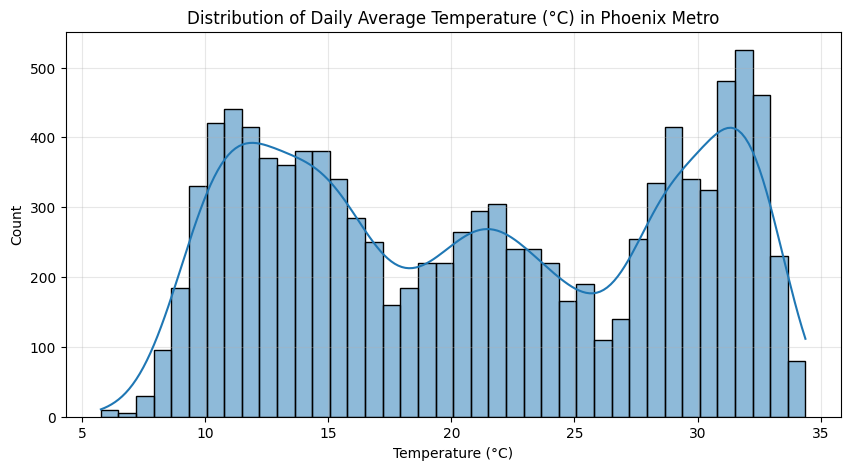

In [48]:
plt.figure(figsize=(10,5))
sns.histplot(temps_az["avg_temp_c"], bins=40, kde=True)
plt.title("Distribution of Daily Average Temperature (°C) in Phoenix Metro")
plt.xlabel("Temperature (°C)")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()

#### 3.0.3 Monthly Mean Temperature Trends

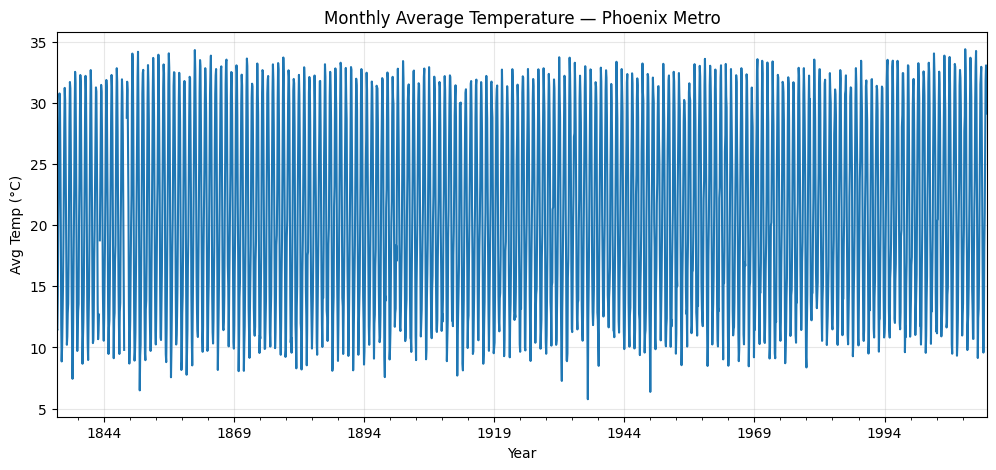

Hottest month: 2009-07-31 00:00:00 34.379
Coldest month: 1937-01-31 00:00:00 5.768000000000002


In [49]:
if "dt" in temps_az.columns:
    ts = temps_az.set_index("dt")["avg_temp_c"].resample("M").mean()

    plt.figure(figsize=(12,5))
    ts.plot()
    plt.title("Monthly Average Temperature — Phoenix Metro")
    plt.ylabel("Avg Temp (°C)")
    plt.xlabel("Year")
    plt.grid(alpha=0.3)
    plt.show()

    print("Hottest month:", ts.idxmax(), float(ts.max()))
    print("Coldest month:", ts.idxmin(), float(ts.min()))
else:
    print("No datetime column available for monthly trend plot.")

#### 3.0.4 Correlation Heatmap

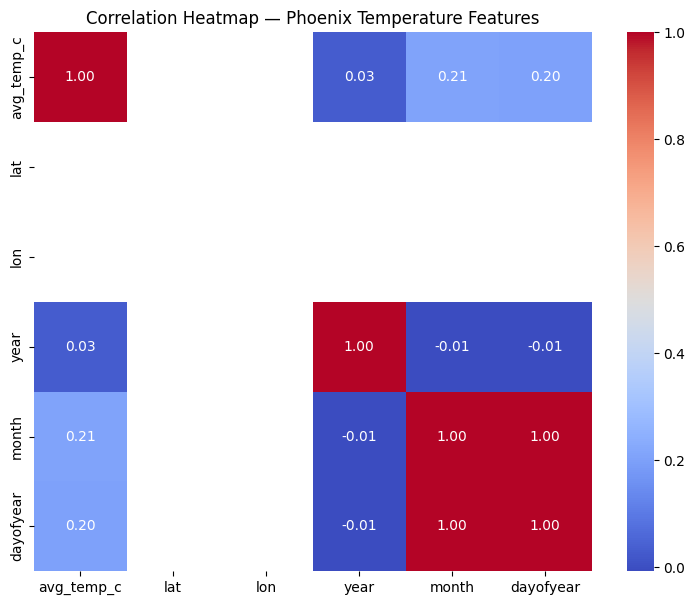

In [50]:
corr_df = temps_az.copy()

# Extract year/month/dayofyear first
if "dt" in corr_df.columns:
    corr_df["year"] = corr_df["dt"].dt.year
    corr_df["month"] = corr_df["dt"].dt.month
    corr_df["dayofyear"] = corr_df["dt"].dt.dayofyear

num_cols = ["avg_temp_c", "lat", "lon", "year", "month", "dayofyear"]
num_cols = [c for c in num_cols if c in corr_df.columns]

plt.figure(figsize=(9,7))
sns.heatmap(corr_df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap — Phoenix Temperature Features")
plt.show()

#### 3.0.5 Temperature vs. Latitude / Longitude

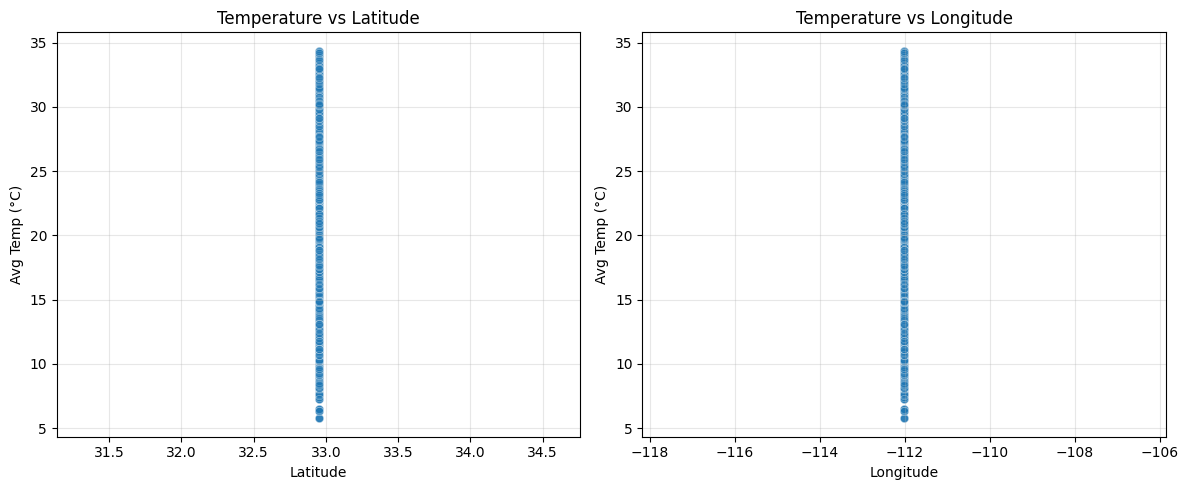

In [51]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.scatterplot(data=temps_az, x="lat", y="avg_temp_c", alpha=0.4)
plt.title("Temperature vs Latitude")
plt.xlabel("Latitude")
plt.ylabel("Avg Temp (°C)")
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
sns.scatterplot(data=temps_az, x="lon", y="avg_temp_c", alpha=0.4)
plt.title("Temperature vs Longitude")
plt.xlabel("Longitude")
plt.ylabel("Avg Temp (°C)")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### 3.0.6 Temperature by City (comparison across Phoenix, Tempe, Mesa, etc.)

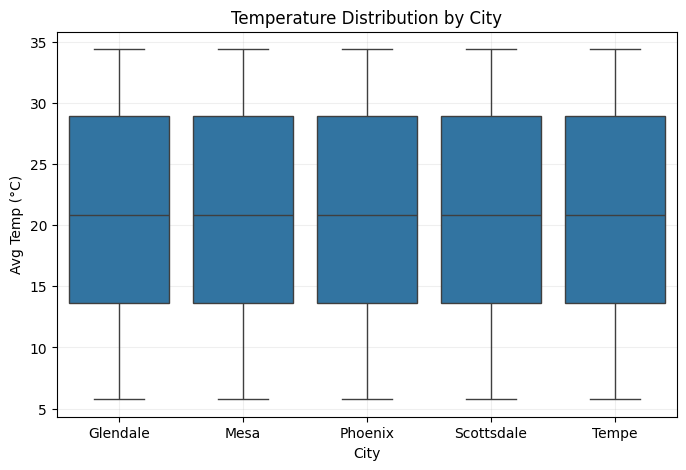

In [52]:
plt.figure(figsize=(8,5))
sns.boxplot(data=temps_az, x="city", y="avg_temp_c")
plt.title("Temperature Distribution by City")
plt.xlabel("City")
plt.ylabel("Avg Temp (°C)")
plt.grid(alpha=0.2)
plt.show()

### 3.1 Baseline Logistic Regression (Calendar + City + Coordinates)

In [54]:
# =============================================================
# 3.1 Baseline Logistic Regression
# Calendar + City + Coordinates (no shade features yet)
# =============================================================

from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# -------------------------------------------------------------
# Prepare dataset
# -------------------------------------------------------------
base = temps_az.dropna(subset=["avg_temp_c"]).copy()

# Calendar features
if "dt" in base.columns:
    base["year"]      = base["dt"].dt.year
    base["month"]     = base["dt"].dt.month
    base["dayofyear"] = base["dt"].dt.dayofyear

# Model input columns
num_cols = ["year", "month", "dayofyear", "lat", "lon"]
num_cols = [c for c in num_cols if c in base.columns]

cat_cols = ["city", "country"]
cat_cols = [c for c in cat_cols if c in base.columns]

X_cols = num_cols + cat_cols

print("Numeric features:", num_cols)
print("Categorical features:", cat_cols)
print("Total X columns:", len(X_cols))

# -------------------------------------------------------------
# Preprocessing Pipeline
# -------------------------------------------------------------
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="drop",
)

clf = Pipeline(steps=[
    ("pre", pre),
    ("lr", LogisticRegression(
        max_iter=1500,
        solver="lbfgs",
        random_state=RANDOM_STATE
    ))
])

# -------------------------------------------------------------
# Cross-validation
# -------------------------------------------------------------
# FIX: KFold handles continuous split generation better here
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

accs, f1s, rocs = [], [], []
fold_info = []

print("\nRunning 5-fold CV for Baseline Logistic Regression...")

# KFold splits based on index, y is optional but we pass it for consistency
for k, (tr, te) in enumerate(cv.split(base[X_cols], base["avg_temp_c"] )):

    # Compute the "hot" threshold on TRAIN ONLY to avoid leakage
    thr = base.iloc[tr]["avg_temp_c"].quantile(0.70)

    # Create binary target: 1 if >= 70th percentile, else 0
    y_train = (base.iloc[tr]["avg_temp_c"] >= thr).astype(int)
    y_test  = (base.iloc[te]["avg_temp_c"] >= thr).astype(int)

    X_train = base.iloc[tr][X_cols]
    X_test  = base.iloc[te][X_cols]

    # Fit
    clf.fit(X_train, y_train)

    # Predictions
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)

    try:
        roc = roc_auc_score(y_test, y_prob)
    except ValueError:
        roc = np.nan   # Edge case: a fold with only one class

    accs.append(acc)
    f1s.append(f1)
    rocs.append(roc)

    fold_info.append({
        "fold": k + 1,
        "threshold_C": float(thr),
        "acc": acc,
        "f1": f1,
        "roc_auc": roc,
        "train_pos_rate": float(y_train.mean()),
        "test_pos_rate": float(y_test.mean()),
        "n_train": len(tr),
        "n_test": len(te),
    })

# -------------------------------------------------------------
# Summary of results
# -------------------------------------------------------------
print("\n=== Baseline Logistic Regression Results (5-fold CV) ===")
print(f"Accuracy:  {np.nanmean(accs):.3f} ± {np.nanstd(accs):.3f}")
print(f"F1 Score:  {np.nanmean(f1s):.3f} ± {np.nanstd(f1s):.3f}")
print(f"ROC-AUC:   {np.nanmean(rocs):.3f} ± {np.nanstd(rocs):.3f}")

diag = pd.DataFrame(fold_info)
display(diag)

Numeric features: ['year', 'month', 'dayofyear', 'lat', 'lon']
Categorical features: ['city', 'country']
Total X columns: 7

Running 5-fold CV for Baseline Logistic Regression...

=== Baseline Logistic Regression Results (5-fold CV) ===
Accuracy:  0.700 ± 0.005
F1 Score:  0.000 ± 0.000
ROC-AUC:   0.607 ± 0.008


,fold,threshold_C,acc,f1,roc_auc,train_pos_rate,test_pos_rate,n_train,n_test
0,1,27.8960,0.695185,0.0,0.602939,0.300140,0.304815,8556,2139
1,2,27.8960,0.695185,0.0,0.597169,0.300140,0.304815,8556,2139
2,3,27.9175,0.701730,0.0,0.615719,0.300023,0.298270,8556,2139
3,4,27.9240,0.702665,0.0,0.602501,0.300257,0.297335,8556,2139
4,5,27.9410,0.706872,0.0,0.617585,0.300140,0.293128,8556,2139


### 3.2 Baseline Regression Models (Predict °C Directly)

In [55]:
# =============================================================
# 3.2 Baseline Regression Models
# Predict avg_temp_c using calendar + lat/lon + city
# =============================================================

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

# Prepare dataset
reg = temps_az.dropna(subset=["avg_temp_c"]).copy()

# Calendar features
if "dt" in reg.columns:
    reg["year"]      = reg["dt"].dt.year
    reg["month"]     = reg["dt"].dt.month
    reg["dayofyear"] = reg["dt"].dt.dayofyear

num_cols = ["year", "month", "dayofyear", "lat", "lon"]
num_cols = [c for c in num_cols if c in reg.columns]

cat_cols = ["city", "country"]
cat_cols = [c for c in cat_cols if c in reg.columns]

X_cols = num_cols + cat_cols
X = reg[X_cols]
y = reg["avg_temp_c"]

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# Preprocessing
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

# Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        n_estimators=200, min_samples_leaf=2, random_state=RANDOM_STATE, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.05, random_state=RANDOM_STATE)
}

# Scorers
def rmse(y_true, y_pred): return mean_squared_error(y_true, y_pred, squared=False)

rmse_scorer = make_scorer(rmse, greater_is_better=False)
mae_scorer  = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer   = make_scorer(r2_score)

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []

print("\nRunning Baseline Regression Models...\n")

for name, model in models.items():
    pipe = Pipeline(steps=[("pre", pre), ("model", model)])

    rmse_scores = -cross_val_score(pipe, X, y, cv=kf, scoring=rmse_scorer)
    mae_scores  = -cross_val_score(pipe, X, y, cv=kf, scoring=mae_scorer)
    r2_scores   =  cross_val_score(pipe, X, y, cv=kf, scoring=r2_scorer)

    results.append({
        "model": name,
        "rmse_mean": rmse_scores.mean(),
        "rmse_std":  rmse_scores.std(),
        "mae_mean": mae_scores.mean(),
        "mae_std":  mae_scores.std(),
        "r2_mean":  r2_scores.mean(),
        "r2_std":   r2_scores.std(),
    })

results_df = pd.DataFrame(results)
display(results_df)


Numeric columns: ['year', 'month', 'dayofyear', 'lat', 'lon']
Categorical columns: ['city', 'country']

Running Baseline Regression Models...



,model,rmse_mean,rmse_std,mae_mean,mae_std,r2_mean,r2_std
0,Linear Regression,NaN,NaN,5.997630,0.073831,0.197769,0.008859
1,Random Forest,NaN,NaN,0.304518,0.014279,0.996364,0.000506
2,Gradient Boosting,NaN,NaN,0.889937,0.011277,0.979311,0.000472


### Section 3.3 Feature Importance and Explainability

=== Top Logistic Regression Coefficients ===


,feature,importance
1,month,3.179046e+00
0,year,5.203487e-02
4,lon,0.000000e+00
3,lat,-1.593894e-15
9,city_Tempe,-4.486412e-02
8,city_Scottsdale,-4.486412e-02
7,city_Phoenix,-4.486412e-02
5,city_Glendale,-4.486412e-02
6,city_Mesa,-4.486412e-02
10,country_United States,-2.243206e-01


=== Top Random Forest Features ===


,feature,importance
2,dayofyear,0.508130
1,month,0.467231
0,year,0.024432
6,city_Mesa,0.000043
8,city_Scottsdale,0.000042
5,city_Glendale,0.000042
7,city_Phoenix,0.000041
9,city_Tempe,0.000039
4,lon,0.000000
3,lat,0.000000


=== Top Gradient Boosting Features ===


,feature,importance
1,month,0.508256
2,dayofyear,0.486598
0,year,0.005146
3,lat,0.000000
4,lon,0.000000
5,city_Glendale,0.000000
6,city_Mesa,0.000000
7,city_Phoenix,0.000000
8,city_Scottsdale,0.000000
9,city_Tempe,0.000000


=== Combined Feature Importance Table ===


,feature,importance_rf,importance_gb,importance_lr
6,dayofyear,0.508130,0.486598,-2.796549e+00
9,month,0.467231,0.508256,3.179046e+00
10,year,0.024432,0.005146,5.203487e-02
1,city_Mesa,0.000043,0.000000,-4.486412e-02
3,city_Scottsdale,0.000042,0.000000,-4.486412e-02
0,city_Glendale,0.000042,0.000000,-4.486412e-02
2,city_Phoenix,0.000041,0.000000,-4.486412e-02
4,city_Tempe,0.000039,0.000000,-4.486412e-02
5,country_United States,0.000000,0.000000,-2.243206e-01
8,lon,0.000000,0.000000,0.000000e+00


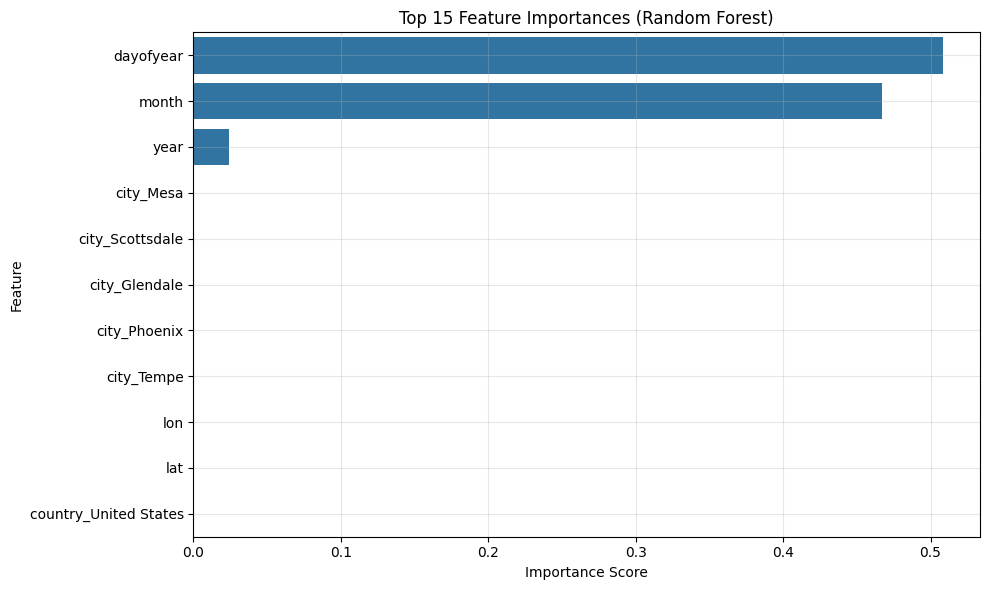

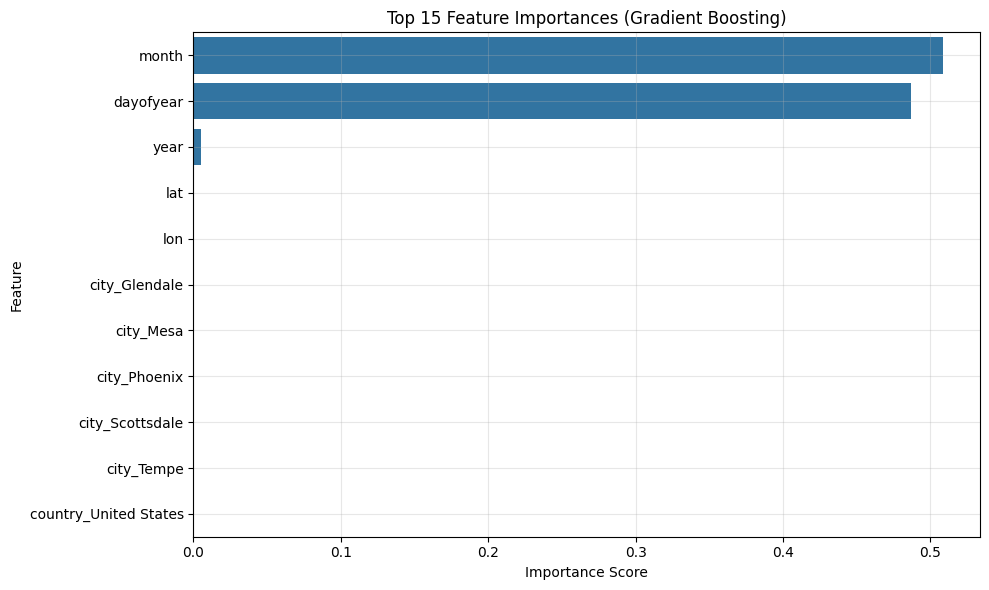

In [56]:
# =============================================================
# 3.3 Feature Importance and Explainability
# =============================================================

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------
# Prepare data
# -------------------------------------------------------------
reg = temps_az.dropna(subset=["avg_temp_c"]).copy()

if "dt" in reg.columns:
    reg["year"]      = reg["dt"].dt.year
    reg["month"]     = reg["dt"].dt.month
    reg["dayofyear"] = reg["dt"].dt.dayofyear

num_cols = ["year", "month", "dayofyear", "lat", "lon"]
num_cols = [c for c in num_cols if c in reg.columns]

cat_cols = ["city", "country"]
cat_cols = [c for c in cat_cols if c in reg.columns]

X_cols = num_cols + cat_cols
X = reg[X_cols]
y = reg["avg_temp_c"]

# Preprocessing
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="drop"
)

# Helper: extract feature names after preprocessing
def get_feature_names(preprocessor, num_cols, cat_cols, X):
    ohe = preprocessor.named_transformers_["cat"]
    cat_new_cols = list(ohe.get_feature_names_out(cat_cols))
    return num_cols + cat_new_cols


# =============================================================
# 3.3.1 Logistic Regression Coefficients
# =============================================================

log_reg = Pipeline([
    ("pre", pre),
    ("model", LogisticRegression(max_iter=1500, random_state=RANDOM_STATE))
])

log_reg.fit(X, (y >= y.quantile(0.70)).astype(int))

# Extract feature names
feature_names = get_feature_names(log_reg.named_steps["pre"], num_cols, cat_cols, X)
coeffs = log_reg.named_steps["model"].coef_.flatten()

lr_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": coeffs
}).sort_values("importance", ascending=False)

print("=== Top Logistic Regression Coefficients ===")
display(lr_importance.head(15))


# =============================================================
# 3.3.2 Random Forest Feature Importance
# =============================================================

rf = Pipeline([
    ("pre", pre),
    ("model", RandomForestRegressor(
        n_estimators=300,
        min_samples_leaf=2,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

rf.fit(X, y)

rf_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": rf.named_steps["model"].feature_importances_
}).sort_values("importance", ascending=False)

print("=== Top Random Forest Features ===")
display(rf_importance.head(15))


# =============================================================
# 3.3.3 Gradient Boosting Feature Importance
# =============================================================

gb = Pipeline([
    ("pre", pre),
    ("model", GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        random_state=RANDOM_STATE
    ))
])

gb.fit(X, y)

gb_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": gb.named_steps["model"].feature_importances_
}).sort_values("importance", ascending=False)

print("=== Top Gradient Boosting Features ===")
display(gb_importance.head(15))


# =============================================================
# 3.3.4 Combined Importance Summary
# =============================================================

combined = (rf_importance
            .merge(gb_importance, on="feature", how="outer", suffixes=("_rf","_gb"))
            .merge(lr_importance, on="feature", how="outer"))

combined = combined.rename(columns={"importance": "importance_lr"})
combined = combined.fillna(0).sort_values("importance_rf", ascending=False)

print("=== Combined Feature Importance Table ===")
display(combined.head(20))


# =============================================================
# 3.3.5 Importance Plot (Random Forest)
# =============================================================

plt.figure(figsize=(10,6))
sns.barplot(data=rf_importance.head(15), x="importance", y="feature")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================
# 3.3.6 Importance Plot (Gradient Boosting)
# =============================================================

plt.figure(figsize=(10,6))
sns.barplot(data=gb_importance.head(15), x="importance", y="feature")
plt.title("Top 15 Feature Importances (Gradient Boosting)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### 3.4 Diagnostics and Error Analysis

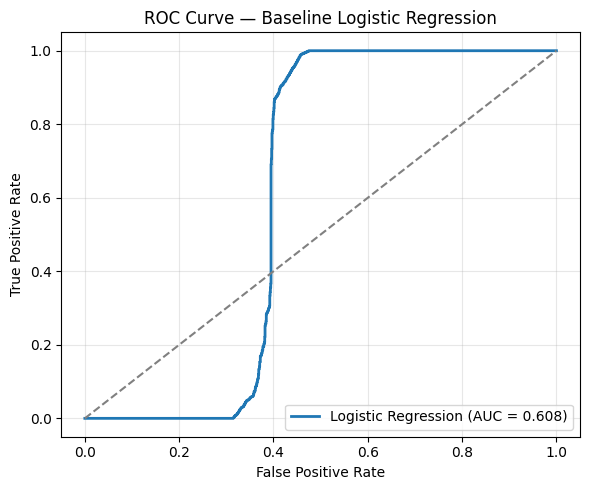

AUC: 0.6081238281339418


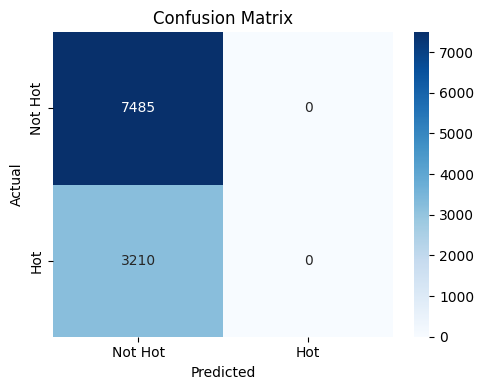

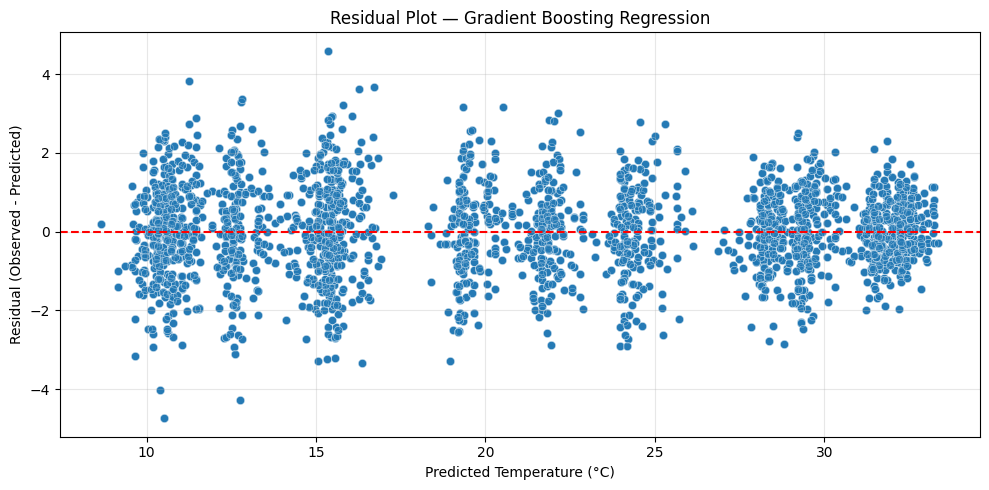

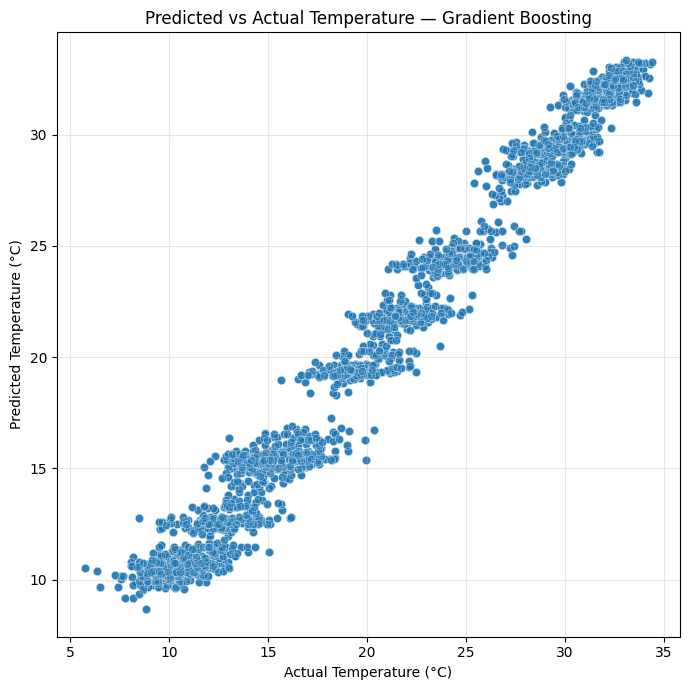

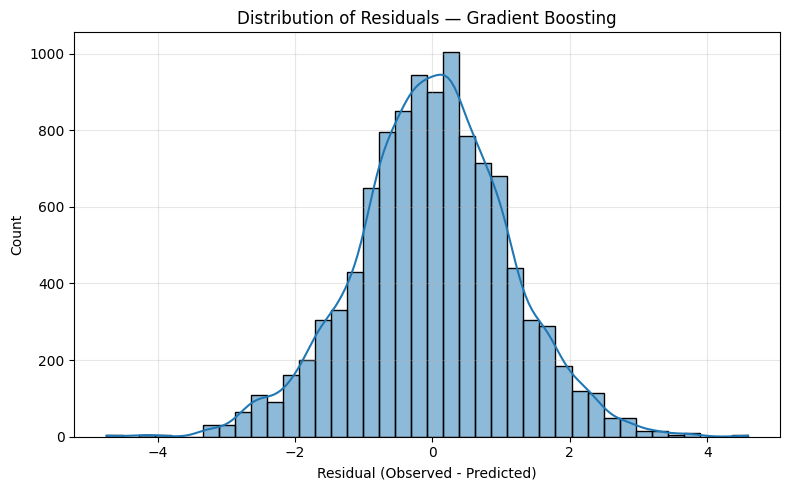

Residual Mean: 1.0090105469244059e-16
Residual Std: 1.1216008191358817


In [57]:
# =============================================================
# 3.4 Diagnostics and Error Analysis
# =============================================================

from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# Helpers
# -------------------------------------------------------------
def plot_confusion(cm, labels):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


# =============================================================
# 3.4.1 ROC Curve for Logistic Regression (from Section 3.1)
# =============================================================

# Refit the baseline model on full dataset for inspection
base = temps_az.dropna(subset=["avg_temp_c"]).copy()

if "dt" in base.columns:
    base["year"]      = base["dt"].dt.year
    base["month"]     = base["dt"].dt.month
    base["dayofyear"] = base["dt"].dt.dayofyear

num_cols = ["year", "month", "dayofyear", "lat", "lon"]
num_cols = [c for c in num_cols if c in base.columns]

cat_cols = ["city", "country"]
cat_cols = [c for c in cat_cols if c in base.columns]

X_cols = num_cols + cat_cols
X = base[X_cols]

# Logistic Regression threshold: use overall 70th percentile
thr = base["avg_temp_c"].quantile(0.70)
y = (base["avg_temp_c"] >= thr).astype(int)

# Fit
clf.fit(X, y)

# Predict probabilities
y_prob_full = clf.predict_proba(X)[:, 1]

# ROC
fpr, tpr, _ = roc_curve(y, y_prob_full)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Baseline Logistic Regression")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("AUC:", roc_auc)


# =============================================================
# 3.4.2 Confusion Matrix (Logistic Regression)
# =============================================================

y_pred_full = clf.predict(X)
cm = confusion_matrix(y, y_pred_full)

plot_confusion(cm, labels=["Not Hot", "Hot"])


# =============================================================
# 3.4.3 Regression Diagnostics
# Fit Gradient Boosting Regression (best baseline regressor from 3.2)
# =============================================================

gb = Pipeline(steps=[
    ("pre", pre),
    ("model", GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.05, random_state=RANDOM_STATE
    ))
])

gb.fit(X, base["avg_temp_c"])
preds = gb.predict(X)

# ---------------- Residual Plot ----------------
residuals = base["avg_temp_c"] - preds

plt.figure(figsize=(10,5))
sns.scatterplot(x=preds, y=residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Temperature (°C)")
plt.ylabel("Residual (Observed - Predicted)")
plt.title("Residual Plot — Gradient Boosting Regression")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# ---------------- Predicted vs Actual ----------------
plt.figure(figsize=(7,7))
sns.scatterplot(x=base["avg_temp_c"], y=preds, alpha=0.4)
plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.title("Predicted vs Actual Temperature — Gradient Boosting")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# =============================================================
# 3.4.4 Error Distribution Histogram
# =============================================================

plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Distribution of Residuals — Gradient Boosting")
plt.xlabel("Residual (Observed - Predicted)")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Residual Mean:", residuals.mean())
print("Residual Std:", residuals.std())
